# Detecting Electric Utility Features in satellite imagery using Deep learning and finding possible Vegetation encroachment near installations
> * 🔬 Data Science
* 🥠 Deep Learning and Object Detection

## Table of Contents

* [Introduction](#Introduction)
* [Export training data for deep learning](#Export-training-data-for-deep-learning)
* [Train the model](#Train-the-model)
 * [Load RetinaNet model architecture](#Load-RetinaNet-model-architecture)
 * [Tuning for optimal learning rate](#Tuning-for-optimal-learning-rate)
 * [Fit the model on the data](#Fit-the-model-on-the-data)
 * [Unfreeze and fine tuning](#Unfreeze-and-fine-tuning)
 * [Save the model](#Save-the-model)
 * [Visualize results in validation set](#Visualize-results-in-validation-set)
 * [Train model, load and detect trees](#Train-model,-load-and-detect-trees)
* [Deploy model and detect electric utility features & trees at scale](#Deploy-model-and-detect-electric-utility-features-&-trees-at-scale)
* [Near analysis to find possible vegetation encroachment near electric utility features](#Near-analysis-to-find-possible-vegetation-encroachment-near-electric-utility-features)
* [Conclusion](#Conclusion)
* [References](#References)

## Introduction

Toward solving this problem, we built a sample workflow to efficiently map the electric utility features and trees in the imagery. Satellite imagery combined with machine learning leads to cost-effective management of the electric grids. This workflow consists of four major operations::

* Building and extracting training data for electric utility and Trees using ArcGIS Pro
* Training a deep learning model i.e. RetinaNet using arcgis.learn
* Model inferencing at scale using ArcGIS Pro
* Proximity analysis between detected objects (Electric utility and trees) feature layers using ArcGIS Pro

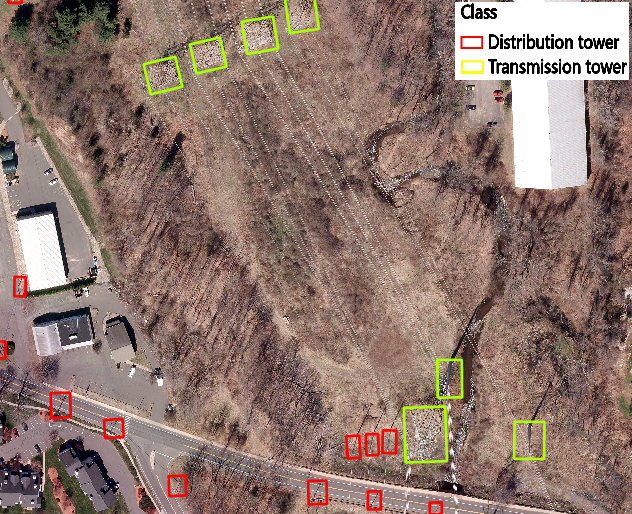

## Export training data for deep learning

Training samples for electric utilities were manually labelled for **Hartford, Connecticut state**. The training data consisted of three classes i.e. Transmission tower, Distribution tower, Sub-station.

Training data can be exported using the `Export training data for deeplearning` tool available in ArcGIS Pro and ArcGIS Image Server

- `Input Raster`: Esri world imagery 2019
- `Input Feature Class or Classified Raster`: feature layer with labelled polygon
- `Class Value Field`: field in the attributes containing class
- `Tile Size X & Tile Size Y`: 256
- `Stride X & Stride Y`: 128
- `Reference System`: Map space
- `Meta Data Format`: Pascal VOC (Visual Object Class)
- `Environments`: Set optimum Cell Size, Processing Extent 

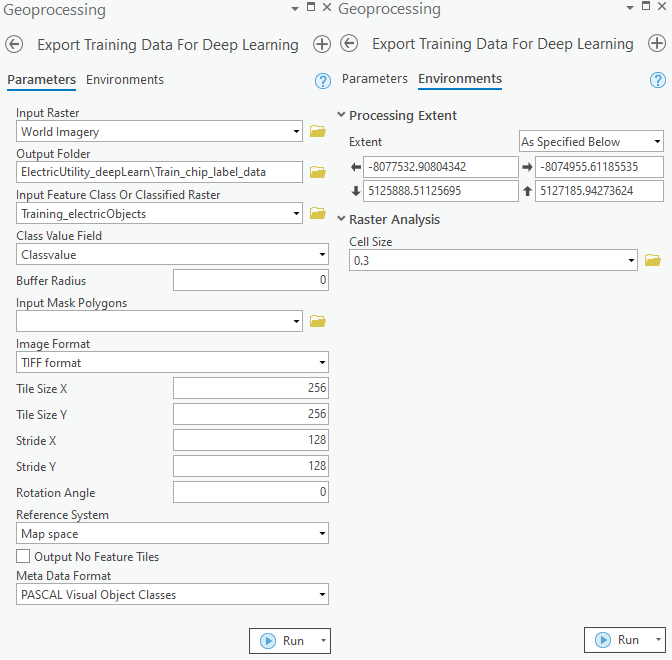

`arcpy.ia.ExportTrainingDataForDeepLearning("World Imagery 2019", r"C:\ElectricUtility_deepLearn\Train_chip_lablel_data", "Training_electricObjects", , "TIFF", 256, 256, 128, 128, "ONLY_TILES_WITH_FEATURES", "PASCAL_VOC_rectangles", 0, "Classvalue", 0, None, 0)`

After filling all details and running the Export Training Data For Deep Learning tool, a code like above will be generated and executed. This will create training data i.e. Image (.tif) and labels (.xml) with necessary files in the specified folder, ready to be used in upcoming steps.

## Train the model

We will select and train a model using `arcgis.learn` module in ArcGIS API for Python. `arcgis.learn` has deep learning tools and capabilities to accomplish the task in this study. As electric utility features are generally small and varied in appearance, RetinaNet model is used, which is one of the best one stage object detection model that works specifically well in case of small and dense objects.

## Necessary imports

In [1]:
from arcgis.learn import RetinaNet, prepare_data

## Prepare data

We will specify the path to our training data and a few hyperparameters. It also helps in transformations and data augmentations on the training data, which enables us to train better model with limited datasets.

- **path**: path of the folder containing training data.
- **class_mapping**: allows for specifying text labels for the classes
- **batch_size**: Number of images your model will train on each step inside an epoch, it directly depends on the memory of your graphic card. 5 worked for us on a 11GB GPU.

This function returns a fast.ai databunch, which will be used further to train the model.

In [2]:
## Path to exported training data in form of chips i.e. Image and Labels using geoprocessing (Export training data for deep learning) tool 

data_path = r'C:\Esri_projects\Electrci_utility_DL\training_chips_labels'

In [3]:
## Load the Data ##
data = prepare_data(data_path, class_mapping = {1:'Dist_tower',2:'Trans_tower',3:'Station'}, batch_size = 10)

In [4]:
## Check the classes in the loaded data ##
data.classes

['background', 'Dist_tower', 'Station', 'Trans_tower']

## Visualize a few samples from your training data
- **rows**: number of rows we want to see in the results

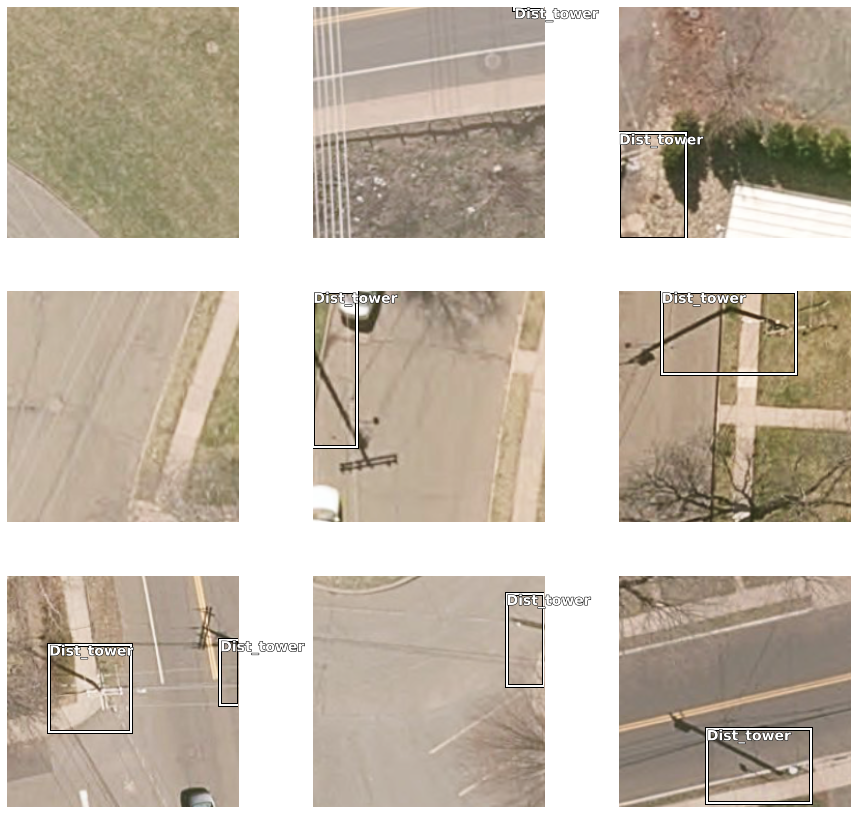

In [5]:
## Visualize random training samples from the data ##
data.show_batch(rows = 3, alpha=1)

The imagery chips have the bounding boxes marked out for electric utility feature type. 

## Load RetinaNet model architecture

The code below initiates a RetinaNet model with a pre-trained Resnet type backbone or other supported backbones. The model return types and bounding boxes for detected electric utility objects in the imagery.  

In [6]:
## Load the model architecture with resnet152 backbone 

retinanet_model = RetinaNet(data, backbone='resnet152')

## Tuning for optimal learning rate
Learning rate is one of the most important hyperparameters during model training as too high/low may cause the model to never converge or learn. `arcgis.learn` leverages fast.ai’s learning rate finder to find an optimum learning rate for training models. We can use the `lr_find()` method to find the optimum learning rate at which can train a robust model fast enough. 

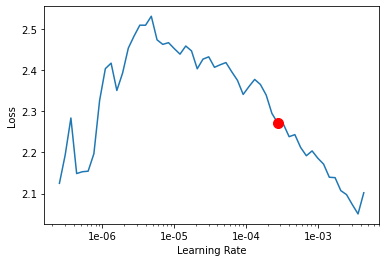

0.0002754228703338166


In [7]:
## Tune the learning rate

lr = retinanet_model.lr_find()
print(lr)

Based on the learning rate finder, the lr = 0.00022908676527677726, which could be used to train our model or if not specified it internally uses the learning rate finder to find optimal learning rate and uses it.

## Fit the model on the data
To train the model, we use the `fit()` method. To start, we will use 10 epochs to train our model. Epoch defines how many times the model is exposed to the entire training set.

In [13]:
retinanet_model.fit(epochs=200, lr=lr)

Training data was split into training and validation set in prepare data step. `fit()` starts the training process and gives losses on training and validation sets. The losses help in accessing the generalizing capability of the model and also prevent overfitting. When a considerable decrease in losses in observed, the model could be saved for further training or inference.

## Unfreeze and fine tuning (optional)
Freezed network layers helps in accelarating the training of the network. Unfreezing the network layers, helps to fine-tune the complete neural network with our own data, leading to better generalization. Hence, After the model was trained with a frozen backbone pre-trained on the ImageNet dataset. The backbone was unfrozen and the model was fine-tuned on the training dataset. 

As per requirement, It can be executed or else we can continue with next step to [Save the model](#Save-the-model).

#### Unfreeze model

In [17]:
retinanet_model.unfreeze()

#### Optimal learning rate

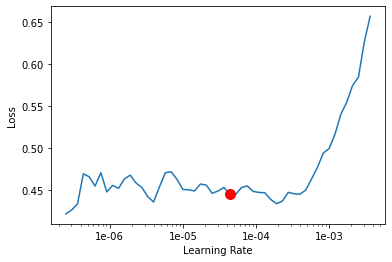

In [18]:
## Find optimal learning rate for the model with unfreezed backbone
lr = retinanet_model.lr_find()

#### Fit model in the data

In [19]:
## Fine-tune for around 10 epochs
retinanet_model.fit(epochs=10,lr=lr)

## Save the model
We will save the model which we trained as a 'Deep Learning Package' ('.dlpk' format). Deep Learning package is the standard format used to deploy deep learning models on the ArcGIS platform. We will use the `save()` method to save the trained model. By default, it will be saved to the 'models' sub-folder within our training data folder.

In [ ]:
retinanet_model.save("Retinanet_finetuned_model_e210")

## Load an intermediate model to train it further
To retrain a saved model, we can load it again using the code below and train it further

In [22]:
retinanet_model.load("Retinanet_model.pth")

## Visualize results in validation set
It is a good practice to see results of the model viz-a-viz ground truth. The code below picks random samples and shows us ground truth and model predictions, side by side. This enables us to preview the results of the model within the notebook.

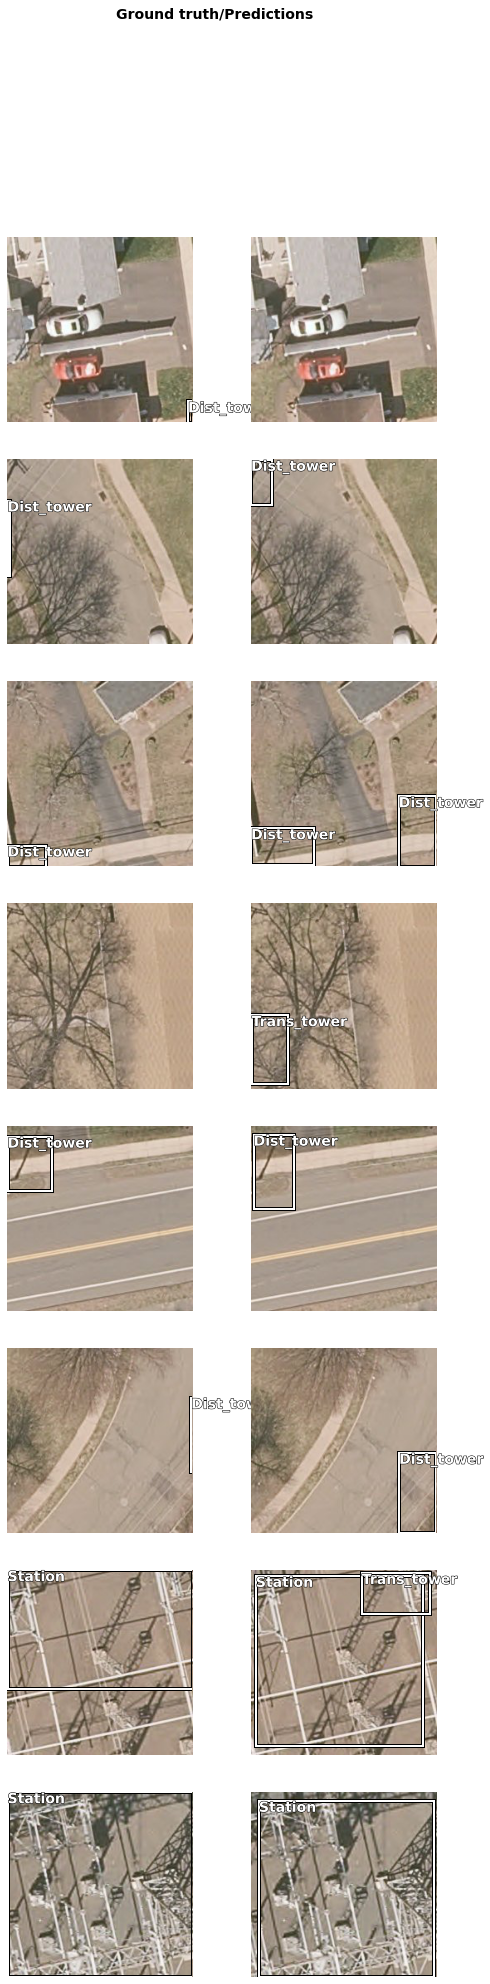

In [21]:
retinanet_model.show_results(rows=8, thresh=0.2)

## Train model, load and detect trees
The same workflow is followed for tree detection from Export training data to detect objects. After training, the model is saved for inference in the next step or for further training. 

## Prepare data

In [2]:
tree_data_path = r'C:\Esri_projects\Electrci_utility_DL\Training_trees_data'##r'C:\Esri_projects\trees_DL\training_chips_labels'

In [3]:
tree_data = prepare_data(tree_data_path, batch_size = 10)

## Visualize a few samples from your trees training data

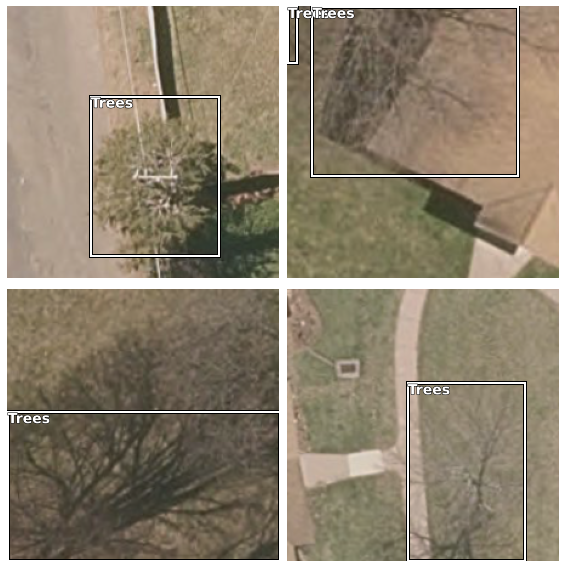

In [36]:
tree_data.show_batch(rows = 2, alpha=1)

## Load RetinaNet model

In [4]:
## Load the model architecture with resnet152 backbone 

retinanet_tree_model = RetinaNet(tree_data, backbone='resnet152')

## Finding optimal learning rate

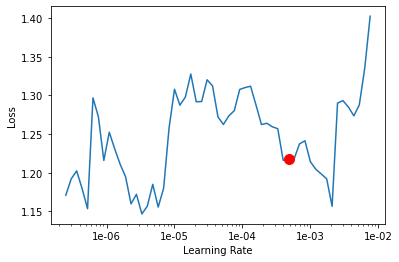

0.0004786300923226385


In [9]:
lr = retinanet_tree_model.lr_find()
print(lr)

## Fit the model on the tree data

In [10]:
retinanet_tree_model.fit(epochs=10, lr=lr, checkpoint= False)

## Visualize results in validation tree dataset

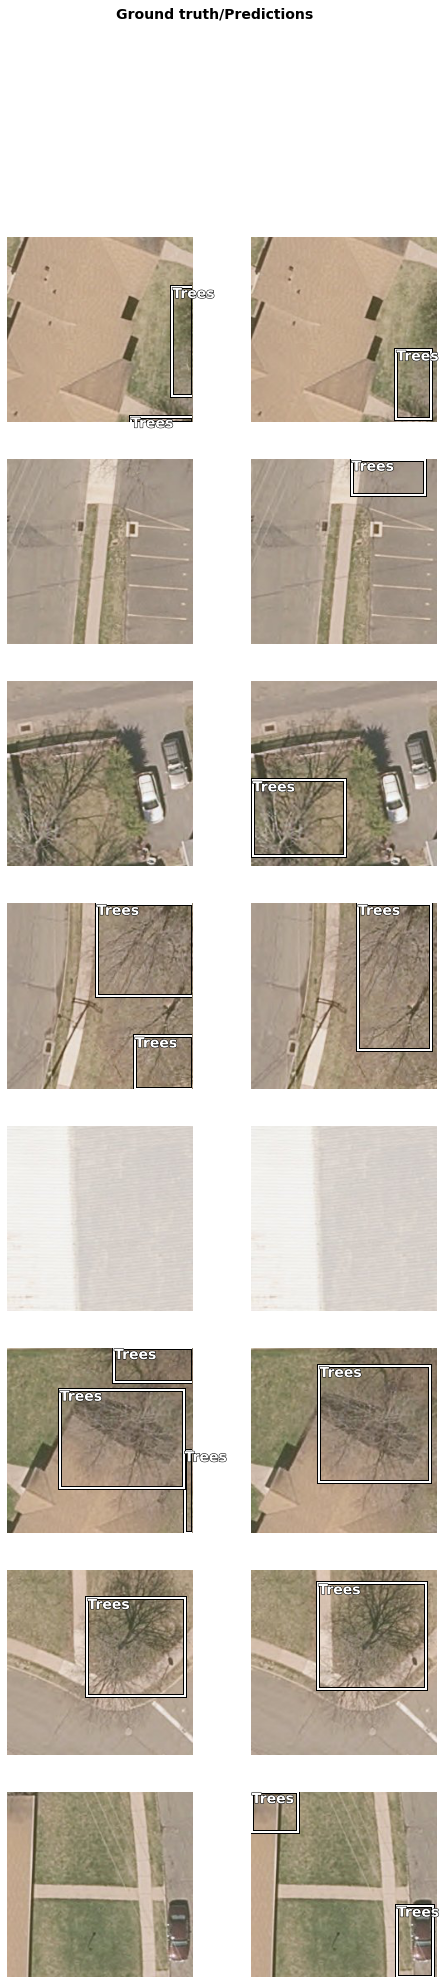

In [14]:
retinanet_tree_model.show_results(rows=8, thresh=0.3)

## Save the model

In [ ]:
retinanet_tree_model.save("Retinanet_tree_model_e10")

## Deploy Model and Detect Electric utility features & Trees at scale

We will use the saved model to detect objects using 'Detect Objects Using Deep Learning' tool available in both ArcGIS Pro and ArcGIS Enterprise. For this sample, we will use the World Imagery base map provided by Esri to detect electric utility features.

- `Input Raster` : ESRI World Imagery
- `Output Detect Objects` : Worldimagery_DetectObjectUs
- `Model Definition` : Retinanet_model_e400.emd
- `padding` : The 'Input Raster' is tiled and the deep learning model runs on each individual tile separately before producing the final 'detected objects feature class'. This may lead to unwanted artifacts along the edges of each tile as the model has little context to detect objects accurately. Padding as the name suggests allows us to supply some extra information along the tile edges, this helps the model to predict better.
- `threshold ` : 0.1
- `nms_overlap` : 0.1
- `Cell Size` : Should be close to at which we trained the model, we specified that at the Export Training Data step .

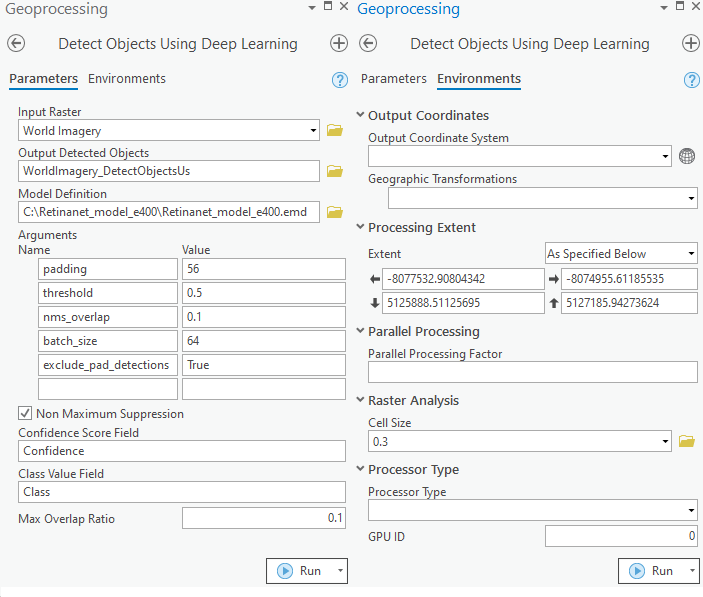

Detect Objects Using Deep Learning returns a feature class that can be further refined using the Definition query and Non Maximum Suppression tool tool. 


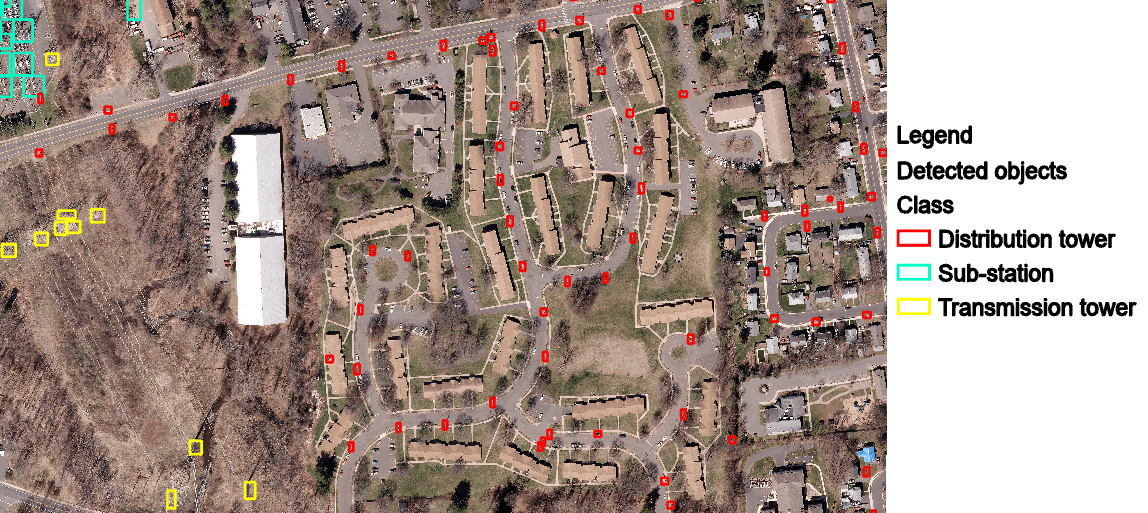

## Near analysis to find possible vegetation encroachment near electric utility features
After model inference on imagery. Detected objects i.e. Electric utility and trees, in the imagery are saved in saved as separate feature layers. The near analysis tool in ArcGIS Pro is used to calculate distance and additional proximity information between the input features (electric utility) and the closest feature in another layer or feature class (Trees).

- `Input Features` : feature layer from detect object tool for electric utility
- `Near Features` : feature layer from detect object tool for trees
- `Search radius` : required distance or range of search
- `Location` : check location parameter checkbox

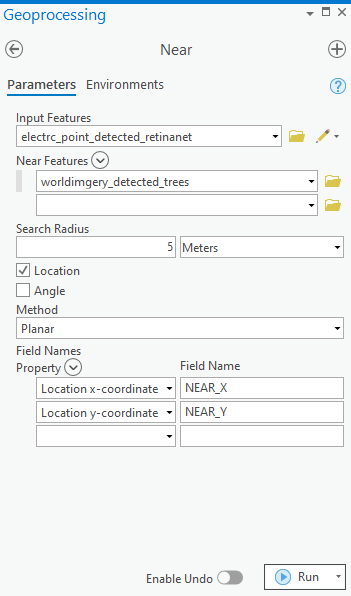

Here the tool finds locations where trees are in the vicinity of 5 m near electric utility features or possible vegetation related outages. The input feature will have two more attribute x (near_x) and y co-ordinates (near_y) of the closest location of the near feature.

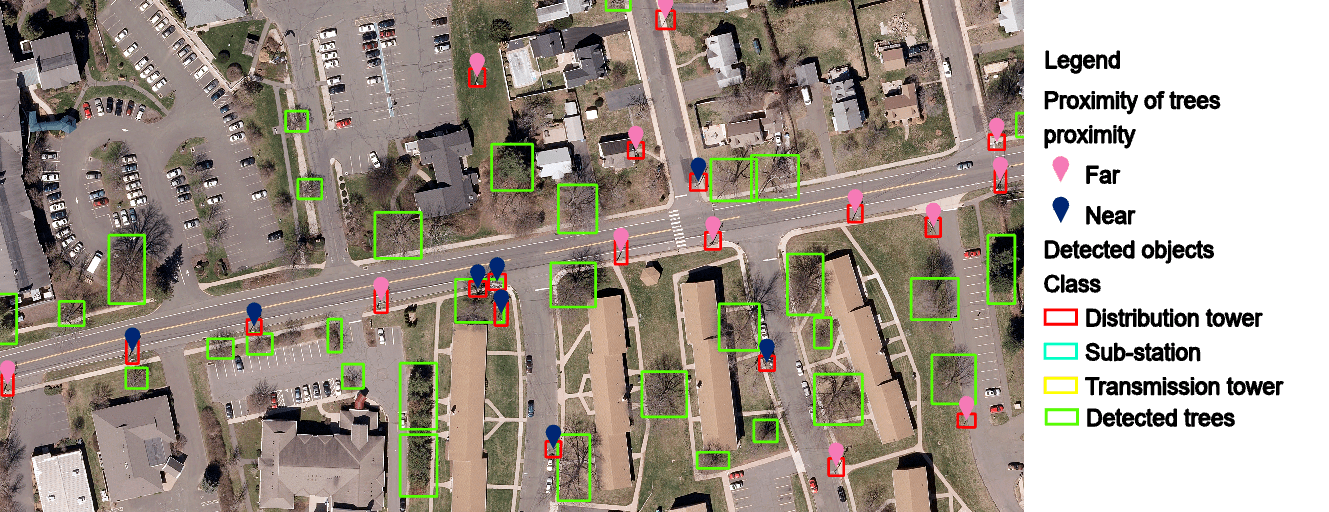

The green and red bounding boxes are trees and electric utility respectively. The red achor show the electric utility object in range of 5m of tree and possible location of vegetation related outage, while yellow show at safe distance.
We have published the outputs from this sample as a hosted feature layer.

## Conclusion


The models available with arcgis.learn were able to detect and map the electric utitity features at scale in the imagery. Further training the models with larger and better data can improve the results at a scale of country. 

The overlay of information from this workflow can assist electric utility industry in cost-effective and efficient management of the electric grid. Data science can help us derive insight from data, but communicating those insights is perhaps as important if not more. We used the ArcGIS Pro to publish the results as a hosted feature layer, which could be viewed as a web-map.

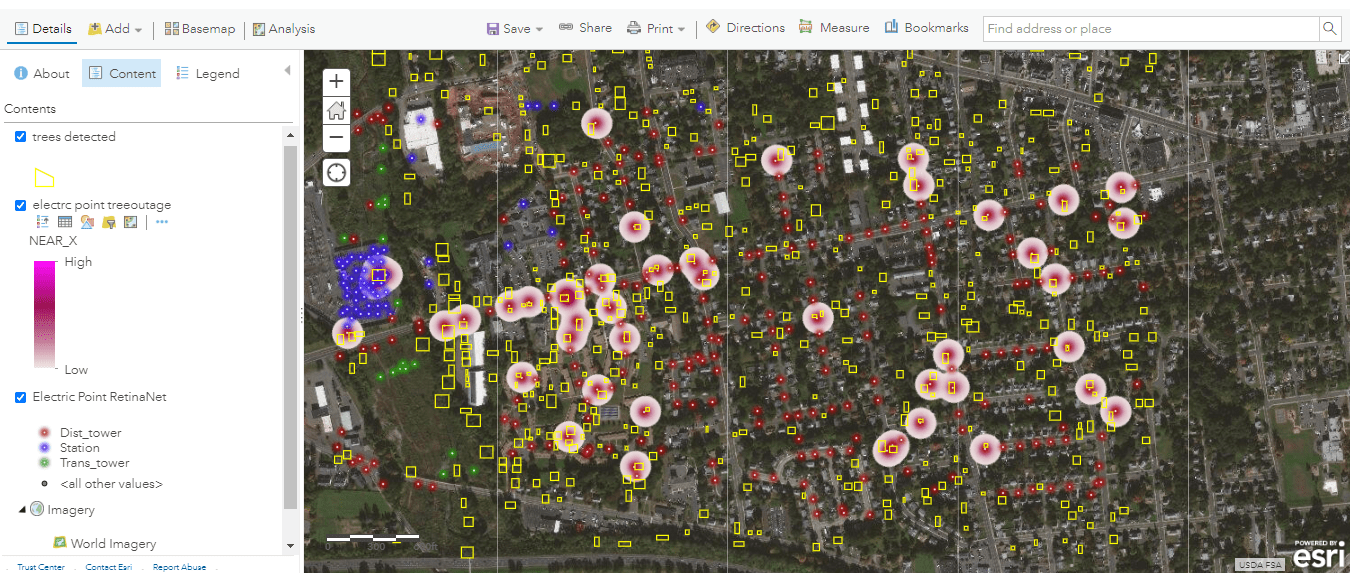

## References
    
[1] Tsung-Yi Lin, Piotr Dollár, Ross Girshick, Kaiming He, Bharath Hariharan: “Feature Pyramid Networks for Object Detection”, 2016; [http://arxiv.org/abs/1612.03144 arXiv:1612.03144].

[2] Tsung-Yi Lin, Priya Goyal, Ross Girshick, Kaiming He: “Focal Loss for Dense Object Detection”, 2017; [http://arxiv.org/abs/1708.02002 arXiv:1708.02002].